In [127]:
'''Parameters:
    - chemical composition (CO/CO2, etc.)
        - first use stationary snow lines to get an initial idea
    - migration of giant planets (start time and rate)
        - GOAL: find out how planetesimals move given planetary migration
            - do not include inner planets, ensure comets are massless test particles
            - first fix Jupiter and Saturn at today's orbits, artificially migrate Neptune and Uranus only
            - use Brasser's migration parameters (initial a and e as stated, final a and e as current solar system)
            - 2 simulations, one for comet bodies beyond Neptune, the other beyond Jupiter
            - plot histograms wrt a
        - NEW GOAL: scattered disk
    - initial distribution of comets
    - D/H ratio
    
    Comets uniformly distributed all the way from 10 to 45 AU, and define a CO2/CO function that should be 
    decreasing between 10 and 30 AU and attach the parameters to the comets. 
    Run the simulations for some time (Myr to see if it is working well). Then finally migrate Jupiter.
    '''

"Parameters:\n    - chemical composition (CO/CO2, etc.)\n        - first use stationary snow lines to get an initial idea\n    - migration of giant planets (start time and rate)\n        - GOAL: find out how planetesimals move given planetary migration\n            - do not include inner planets, ensure comets are massless test particles\n            - first fix Jupiter and Saturn at today's orbits, artificially migrate Neptune and Uranus only\n            - use Brasser's migration parameters (initial a and e as stated, final a and e as current solar system)\n            - 2 simulations, one for comet bodies beyond Neptune, the other beyond Jupiter\n            - plot histograms wrt a\n        - NEW GOAL: scattered disk\n    - initial distribution of comets\n    - D/H ratio\n    \n    Comets uniformly distributed all the way from 10 to 45 AU, and define a CO2/CO function that should be \n    decreasing between 10 and 30 AU and attach the parameters to the comets. \n    Run the simulati

In [422]:
import copy
import numpy as np
import scipy as sp
import rebound
import reboundx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [287]:
#Ignore for now

def chemratio(a):
     return 0.1005*a - 0.995

In [288]:
#Set locations for comets
def comets_loc(inner_lim, outer_lim, n_comets):
    a_comets = np.random.uniform(low = inner_lim, high = outer_lim , size = n_comets)
    return a_comets

In [289]:
#Histogram plot function
def plothist(orbits, sim_num):
    fig, ax = plt.subplots(figsize=(8,8))
    binwidth = 5
    plt.hist(orbits, bins=np.arange(min(orbits), max(orbits) + binwidth, binwidth))
    plt.title("Final semi-major axes of comets, "+str(sim_num))
    plt.xlabel("Orbit Distance (AU)")
    plt.ylabel("Frequency")
    plt.grid()
    #plt.savefig(("figures/"+feature+" "+score_metric+" Scores "+str(str(regressor)).split("(",1)[0])+" (Earth Masses).png", bbox_inches='tight', format='png')

In [543]:
#Distance vs. time plot function
def plot_a_time(orbits_list, t_list, sim_num):
    a_orbits_list = copy.deepcopy(orbits_list)
    for i in range(len(a_orbits_list)):
        for j in range(len(a_orbits_list[i])):
            a_orbits_list[i][j] = float((str(a_orbits_list[i][j]).split('a=', 1)[-1]).split(' ',1)[0])

    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8)) 
    for m in range(len(list(map(list, zip(*a_orbits_list))))):
        if m < len(planets_list):
            plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[m], linewidth=5)
        else:
            plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[m])
        axes = plt.gca()
        if max(list(map(list, zip(*a_orbits_list)))[m]) > 70.:
            axes.set_ylim([0,70])
    for n in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[n], label=planets_list[n]))
    plt.legend(handles=patches, loc="best")
    plt.title("Semi-major axis vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Semi-Major Axis (AU)")
    plt.grid()
    #plt.savefig(("figures/"+feature+" "+score_metric+" Scores "+str(str(regressor)).split("(",1)[0])+" (Earth Masses).png", bbox_inches='tight', format='png')

In [544]:
#Distance vs. time plot function
def plot_e_time(orbits_list, t_list, sim_num):
    e_orbits_list = copy.deepcopy(orbits_list)
    for i in range(len(e_orbits_list)):
        for j in range(len(e_orbits_list[i])):
            e_orbits_list[i][j] = float((str(e_orbits_list[i][j]).split('e=', 1)[-1]).split(' ',1)[0])

    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8)) 
    for m in range(len(list(map(list, zip(*e_orbits_list))))):
        if m < len(planets_list):
            plt.plot(t_list,list(map(list, zip(*e_orbits_list)))[m], linewidth=5)
        else:
            plt.plot(t_list,list(map(list, zip(*e_orbits_list)))[m])
        axes = plt.gca()
        if max(list(map(list, zip(*e_orbits_list)))[m]) > 1.:
            axes.set_ylim([0,1])
    for n in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[n], label=planets_list[n]))
    plt.legend(handles=patches, loc="best")
    plt.title("Eccentricity vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Eccentricity")
    plt.grid()
    #plt.savefig(("figures/"+feature+" "+score_metric+" Scores "+str(str(regressor)).split("(",1)[0])+" (Earth Masses).png", bbox_inches='tight', format='png')

In [551]:
def simulation(tmax,T_ce,n_comets,tau_timestep_num,a_i_list,a_f_list,e_i_list,e_f_list,comets_loc):
    #Call simulations stuffs
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.units = ('yr', 'AU', 'Msun')

    #Retrieve planet data from file
    try:
        sim = rebound.Simulation.from_file("solarsystem.bin")
    except:
        sim.add('sun')
        sim.add('jupiter')
        sim.add('saturn')
        #sim.add('uranus')
        sim.add(m=4.3645e-5,a=a_i_list[2], e=e_i_list[2], inc=0., Omega=0, omega=0, f=0 )
        #sim.add('neptune')
        sim.add(m=5.1483e-5,a=a_i_list[3], e=e_i_list[3], inc=0., Omega=0, omega=0, f=0 )
        sim.save("solarsystem.bin")

    print("Jupiter: "+str(sim.particles[1]))
    print("")
    print("Saturn: "+str(sim.particles[2]))
    print("")
    print("Uranus: "+str(sim.particles[3]))
    print("")
    print("Neptune: "+str(sim.particles[4]))
    print("")
    
    objects = ["Jupiter","Saturn","Uranus","Neptune"]

    #Call reboundx for additional forces
    rebx = reboundx.Extras(sim)
    #Add in force that determines planet migration 
    #rebx.add("modify_orbits_forces")
    mod_effect = rebx.add("modify_orbits_direct")
    mod_effect.params["p"] = 0.

    #Timesteps at which tau is recalculated
    times = np.linspace(0, T_ce, tau_timestep_num)
    
    #NOTE: Changing tau_a (as it increases with respect to time) DOES NOT alter the integration time, instead,
    #tau_a merely alters acceleration (which then determines position)
    #The amount of integration steps are independent to tau_a recalculations, 
    #and merely uses acceleration to calculate orbit parameters
    #i.e. integration time will be same regardless of tau_a
    #Computing time only increases because python now has to calculate through the following functions
   
    for i in xrange(0,n_comets): 
        sim.add(a=comets_loc[i], e=0.15, inc=0., Omega=0, omega=np.random.random()*2*np.pi, f=np.random.random()*2*np.pi)
        objects.append(str(i))
        sim.particles[-1].params["CO/CO2"] = chemratio(comets_loc[i])
        
    sim.exit_max_distance=1e99
    orbits_list, t_list = [], []

    if sim.t < T_ce:
        print("t < T_ce")
        for time in times:
            sim.particles[3].params["tau_a"] = abs(T_ce/(2.*np.log(a_i_list[2]/a_f_list[2])))/(1.-(sim.t/T_ce))
            sim.particles[4].params["tau_a"] = abs(T_ce/(2.*np.log(a_i_list[3]/a_f_list[3])))/(1.-(sim.t/T_ce))
            sim.particles[3].params["tau_e"] = -abs(T_ce/(2.*np.log(e_i_list[2]/e_f_list[2])))/(1.-(sim.t/T_ce))
            sim.particles[4].params["tau_e"] = -abs(T_ce/(2.*np.log(e_i_list[3]/e_f_list[3])))/(1.-(sim.t/T_ce))
            sim.integrate(time)
            print("t = "+str(sim.t))
            orbits = sim.calculate_orbits()
            orbits_list.append(orbits)
            t_list.append(sim.t)
            
        for orbit in orbits:
            print(("%s: "+str(orbit)) % (objects[orbits.index(orbit)]))
            print("")
            
        else:
            print('t > T_ce')
            sim.particles[3].params["tau_a"] = 1e99 #after time reaches T_ce, tau_a becomes infinity (time for planets to move additional distance is infinite, i.e. plaents don't move)
            sim.particles[4].params["tau_a"] = 1e99
            sim.particles[3].params["tau_e"] = -1e99
            sim.particles[4].params["tau_e"] = -1e99
            sim.integrate(tmax)
            #Display orbital parameters for each object at each time iteration
            print("t = "+str(sim.t))
            orbits = sim.calculate_orbits()
            orbits_list.append(orbits)
            t_list.append(sim.t)

            for orbit in orbits:
                print(("%s: "+str(orbit)) % (objects[orbits.index(orbit)]))
                print("")
    sim.move_to_com()

    return sim, orbits, orbits_list, t_list

In [546]:
#Set parameters

n_comets = 5
a_neptune = 30.05
tau_timestep_num = 500

a_comets_1 = comets_loc(30.,45.,n_comets)
dist_name_1 = "30-45 AU Initial Distribution"
a_comets_2 = comets_loc(5.,45.,n_comets)
dist_name_2 = "5-45 AU Initial Distribution"

#tmax is the total simulation time
#T_ce is the time at which the planetary bodies stop moving (but the comets will move)
tmax = 1e6
T_ce = 5e5

#Set the semi-major axis and eccentricity timescales for Uranus and Neptune only
a_i_list = [5.2044, 9.5826, 17.5, 27.5]
a_f_list = [5.2044, 9.5826, 19.2184, 30.1104]
e_i_list = [0.0489, 0.0565, 0.2, 0.3]
e_f_list = [0.0489, 0.0565, 0.0463, 0.00946]

In [547]:
#Do simulation
sim_1, orbits_1, orbits_list_1, t_list_1 = simulation(tmax,T_ce,n_comets,tau_timestep_num,a_i_list,a_f_list,e_i_list,e_f_list,a_comets_1)

Jupiter: <rebound.Particle object, m=0.0009547919152112404 x=-3.595431385544334 y=-4.032022601134785 z=0.09714578884075548 vx=2.0244891751547915 vy=-1.703167509152971 vz=-0.038215534254472903>

Saturn: <rebound.Particle object, m=0.0002858856727222417 x=0.7368153983864792 y=-10.030888353537803 z=0.14507993094833474 vx=1.9201713111471956 vy=0.1427229082484339 vz=-0.0789103949491221>

Uranus: <rebound.Particle object, m=4.3645e-05 x=17.462759184691784 y=9.259572562341644e-06 z=3.373415442094606e-05 vx=1.2450442489439678e-05 vy=1.505825423968146 vz=2.652869210298909e-07>

Neptune: <rebound.Particle object, m=5.1483e-05 x=27.41602046688487 y=9.259572562341642e-06 z=3.3734154420946054e-05 vx=1.2450442489439676e-05 vy=1.2025138456769042 vz=2.6528692102989086e-07>

t < T_ce
t = 0.0
t = 1002.0040080160321
t = 2004.0080160320642
t = 3006.0120240480965
t = 4008.0160320641285
t = 5010.0200400801605
t = 6012.024048096193
t = 7014.0280561122245
t = 8016.032064128257
t = 9018.036072144288
t = 10020.

t = 331663.3266533066
t = 332665.3306613227
t = 333667.3346693387
t = 334669.33867735474
t = 335671.34268537076
t = 336673.3466933868
t = 337675.3507014028
t = 338677.35470941884
t = 339679.35871743486
t = 340681.36272545095
t = 341683.366733467
t = 342685.370741483
t = 343687.374749499
t = 344689.37875751505
t = 345691.3827655311
t = 346693.3867735471
t = 347695.3907815631
t = 348697.39478957915
t = 349699.39879759523
t = 350701.40280561126
t = 351703.4068136273
t = 352705.4108216433
t = 353707.41482965933
t = 354709.41883767536
t = 355711.4228456914
t = 356713.4268537074
t = 357715.4308617235
t = 358717.4348697395
t = 359719.43887775554
t = 360721.44288577157
t = 361723.4468937876
t = 362725.4509018036
t = 363727.45490981964
t = 364729.45891783567
t = 365731.4629258517
t = 366733.4669338678
t = 367735.4709418838
t = 368737.4749498998
t = 369739.47895791585
t = 370741.4829659319
t = 371743.4869739479
t = 372745.4909819639
t = 373747.49498997995
t = 374749.49899799604
t = 375751.503006

In [552]:
sim_2, orbits_2, orbits_list_2, t_list_2 = simulation(tmax,T_ce,n_comets,tau_timestep_num,a_i_list,a_f_list,e_i_list,e_f_list,a_comets_2)

Jupiter: <rebound.Particle object, m=0.0009547919152112404 x=-3.595431385544334 y=-4.032022601134785 z=0.09714578884075548 vx=2.0244891751547915 vy=-1.703167509152971 vz=-0.038215534254472903>

Saturn: <rebound.Particle object, m=0.0002858856727222417 x=0.7368153983864792 y=-10.030888353537803 z=0.14507993094833474 vx=1.9201713111471956 vy=0.1427229082484339 vz=-0.0789103949491221>

Uranus: <rebound.Particle object, m=4.3645e-05 x=17.462759184691784 y=9.259572562341644e-06 z=3.373415442094606e-05 vx=1.2450442489439678e-05 vy=1.505825423968146 vz=2.652869210298909e-07>

Neptune: <rebound.Particle object, m=5.1483e-05 x=27.41602046688487 y=9.259572562341642e-06 z=3.3734154420946054e-05 vx=1.2450442489439676e-05 vy=1.2025138456769042 vz=2.6528692102989086e-07>

t < T_ce
t = 0.0
t = 1002.0040080160321
t = 2004.0080160320642
t = 3006.0120240480965
t = 4008.0160320641285
t = 5010.0200400801605
t = 6012.024048096193
t = 7014.0280561122245
t = 8016.032064128257
t = 9018.036072144288
t = 10020.

t = 330661.3226452906
t = 331663.3266533066
t = 332665.3306613227
t = 333667.3346693387
t = 334669.33867735474
t = 335671.34268537076
t = 336673.3466933868
t = 337675.3507014028
t = 338677.35470941884
t = 339679.35871743486
t = 340681.36272545095
t = 341683.366733467
t = 342685.370741483
t = 343687.374749499
t = 344689.37875751505
t = 345691.3827655311
t = 346693.3867735471
t = 347695.3907815631
t = 348697.39478957915
t = 349699.39879759523
t = 350701.40280561126
t = 351703.4068136273
t = 352705.4108216433
t = 353707.41482965933
t = 354709.41883767536
t = 355711.4228456914
t = 356713.4268537074
t = 357715.4308617235
t = 358717.4348697395
t = 359719.43887775554
t = 360721.44288577157
t = 361723.4468937876
t = 362725.4509018036
t = 363727.45490981964
t = 364729.45891783567
t = 365731.4629258517
t = 366733.4669338678
t = 367735.4709418838
t = 368737.4749498998
t = 369739.47895791585
t = 370741.4829659319
t = 371743.4869739479
t = 372745.4909819639
t = 373747.49498997995
t = 374749.4989979

Widget(N=10, count=2, height=300.0, orbit_data=b'\xb2-GAV\xc4\x1eB\xb7\xe4\x87>\xbd|\xa6@\x92@\x1d=\x88D\x8a\xbf\x89\x08#?\x10\xa5\n@\xb7\xd5\xbd<\xac*GAC\xc9\x1eB`\xde\x87>\x9c\xb4\x18A\x00\xc2\x80=\xbc)\x03\xc0\xb1\x95\xcc>`\xe7\x97?\xb3\x1f\xc9<\xe94GA\xfc\xc7\x1eBi\xd5\x87>\x04\xc0\x99A\x86\xc32=\xfc\xf2\r\xbe\xb3\x9b#@\xa5\xb8\xfa?\x81\xf4F=\xd53GA5\xc7\x1eB\xc9\xd8\x87>\x05\xe8\xf0A\x0e\xe2\x9b;v\xed\x1a\xc0&\xc9&\xbfJC\xd2?c\xbcD=\xba4GA\xa2\xc5\x1eB\x1c\xd8\x87>\xdf\xda$B\x83\xb0\x10>\x91\xbc\x8f\xbed\xbe/@\xe2\x80\x12@\xa2\x88\xcf=\xba4GA\xa2\xc5\x1eB\x1c\xd8\x87>q\x9f?BEwv>\xcc./@E\x84\x0e\xc0=\xc75\xc0N\\\xff<\xba4GA\xa2\xc5\x1eB\x1c\xd8\x87>t\x81\xedA\x1f\xa6\x9d>\xd3\xe0\xd3?Z.7\xc0\xe2\x9f\xfd?\xb1n\xd1=\xba4GA\xa2\xc5\x1eB\x1c\xd8\x87>\xe660B\x17\xc7\x1e>w\x08C\xc0\xa8\x0c\x03?N\xb85@\xc1G\x95=\xba4GA\xa2\xc5\x1eB\x1c\xd8\x87>\xc8\x05\x12B\x06f\x83>6\x0b @\xd2k\xa9>\x88\x1a\xbd?\xd0\xe0\xe8=', orbits=True, orientation=(0.0, 0.0, 0.0, 1.0), overlay='REBOUND (ias15), N=10, t=1e+06', particle_data=b'\xb2-GAV\xc4\x1eB\xb7\xe4\x87>\xcc\xe6\x16;#\r\xd87A\xabV\xb8\x00\x00\x00\x00\xa8\xcb:A\xda\xf02B\x11\xd9[>\xb7\x880\xc0\x85z\x04\xbfRPt=\x00\x00\x00\x00\x9b\xa1\xa9A!L\rB$F\xd3<]IH?\x922\xe9?;U\x89\xba\x00\x00\x00\x00K\xe8\xcc@\xf6\xb9\xb2A6G[?0+\xb5?v\xc2\xf8\xbeLE`\xbd\x00\x00\x00\x00\x98\x9c\x85A\xd7d\x1cAZ\xbf(>\x1bp\x90?\xec!(>m\xea_\xbd\x00\x00\x00\x002w`A\x19\x94\x87@d\x19!@\x9b\n\x8f?\n\xb1\xa9=x\x90\xba\xbd\x00\x00\x00\x00\xa5\x87\xdb\xc1n\xa3\x15\xc0.\xe9\x92?\x95n\xef><\xc7\x10\xbf\xb8j\xad<\x00\x00\x00\x00=0\x00B\x1c\xbekB\xa1y\x17\xc0mS\x0f\xbf,i\x8d?\xfd3\xf3;\x00\x00\x00\x00c\xc3sB\xc6U[B\x11\t\xec\xbfER\x83\xbe_\x93D?\xa4hD\xbd\x00\x00\x00\x00\xa3<\x8a\xc0\xbd\x9cK>o.\xe0?\xda}7?\x92n\xf9\xbe\xad\x89\xb1\xbd\x00\x00\x00\x00', scale=54.09, t=1000000.0, width=500.0)

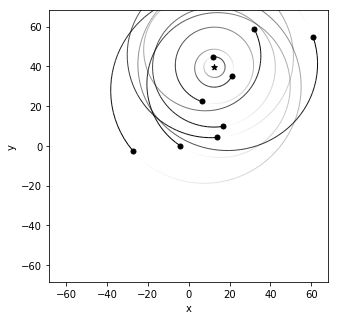

In [553]:
#Plot widgets
fig = rebound.OrbitPlot(sim_1)
sim_1.getWidget(size=(500,300),scale=1.8*a_neptune)

Widget(N=10, count=2, height=300.0, orbit_data=b'5H\xe1\xba\xc9\r\xa6\xba\xd7\xdb\xc98\xbd|\xa6@\xab@\x1d=\xa7H\x8a\xbf`\x08#?\x10\xa5\n@\xb3\xd5\xbd<s\xfb \xbb\x19Dh;A\xbbH8\x9b\xb4\x18A\r\xc2\x80=\x0f,\x03\xc0\xdc\x95\xcc>l\xe7\x97?\xaf\x1f\xc9<\x0c\xb868em\x16;\x1f`\xac\xb7\x10\xc0\x99A\xf2\xc32=\xb8\xe3\x0b\xbe\xf3\x9c#@\x8c\xb8\xfa?~\xf4F=\xb2\re\xb9\xdc\xa1\xc9:\x927\xad6\xfc\xe7\xf0Ae\xe1\x9b;\xe0\xf1\x1a\xc0L\xbd&\xbfKC\xd2?b\xbcD=\xad\xbdp\xa6\x88\xc8\x7f\xa6\xfb\x89{#\xf0\x91\x1cBC\xb3\xff=\xd5\x94\x90\xbf\x1ci\xd0\xbf\x90M\x94?U;q=\xad\xbdp\xa6\x88\xc8\x7f\xa6\xfb\x89{#x\xfb\x1fB\xb1+\x08>\xf9-\xf8?\xceP\x89?\x03\x98\xf6?\x83"\xdb=\xad\xbdp\xa6\x88\xc8\x7f\xa6\xfb\x89{#\xa0J\x0bBA\x0bI>\xfe\xb02\xc0\x17G\xe5>\x84]\x02@\x92\xaf\xa0=\xad\xbdp\xa6\x88\xc8\x7f\xa6\xfb\x89{#\xe1\xe2X\xc2w\x06\x8c?\x11\xc8c\xc0\xa3\xc6)@\xe7X\n?Og\x12>\xad\xbdp\xa6\x88\xc8\x7f\xa6\xfb\x89{#\x074\xebA\xc0)\xf6=\xe7o\x9a\xc01\x1d @\xe1\xf7\xca\xbeL\xff\x8b=', orbits=True, orientation=(0.0, 0.0, 0.0, 1.0), overlay='REBOUND (ias15), N=10, t=1e+06', particle_data=b'5H\xe1\xba\xc9\r\xa6\xba\xd7\xdb\xc98\xd5\x14\x16;\x05\xcdp\xb7\xd0\xbdW\xb8\x00\x00\x00\x00\x10gF\xbf\xbcZ\xa1@\x1akO\xbd\xcd\x890\xc0@f\x04\xbfZLt=\x00\x00\x00\x00H\x0c\x0cAQ\xd6\x8b\xc0:Gu\xbe*YH?\x1b-\xe9?OI\x8a\xba\x00\x00\x00\x00UX\xc0\xc0\xbf\xea\x8a\xc1"\xff\x16?\xf3J\xb5?\xbcT\xf7\xbe\x99\xaa`\xbd\x00\x00\x00\x00O\xf3\x87@\xa1Y\xef\xc1\x98\x9e\xcd\xbd(p\x90?\x07\xfd\'>\x0b\xeb_\xbd\x00\x00\x00\x00\x8bs\x87\xbf\xed:\x12\xc2\x05mN\xbf\xec\xb9\x88?d\x87\xad=+,d\xbd\x00\x00\x00\x00\x0bF\x14A\x9b\xd1 \xc2g$\x12?`%t?\xc3\xb9\xb9=^\x9a\xcb\xbd\x00\x00\x00\x00\xb32\x1cB\x9cTG\xc1\xf5X\x13\xc0\xb5\x91I>\xa6\xaf]?\x86\xf75\xbd\x00\x00\x00\x00\xf0\xda.IB\x01\x84\xc8I\xc8\xa8\xc7\x919K?`h\x99\xbe\xd7(\xc4\xbd\x00\x00\x00\x00\xcd\x95\xd0\xc1\xf9\x1b:\xc1aA\xb6\xbf\x89\xd9\xb6>\xce]\x91\xbfF\x1c\x7f\xbd\x00\x00\x00\x00', scale=54.09, t=1000000.0, width=500.0)

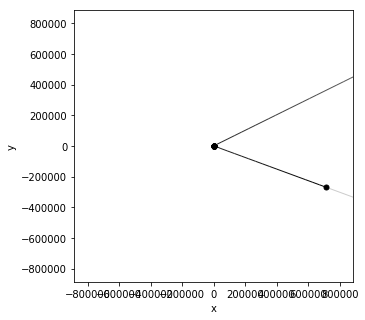

In [554]:
fig = rebound.OrbitPlot(sim_2)
sim_2.getWidget(size=(500,300),scale=1.8*a_neptune)

[41.21373982393169, 47.90570304999189, 29.688210013107327, 44.05361067635742, 36.505646251738156]
[39.14251755303297, 39.99557361648172, 34.82287502963356, -54.221561260090695, 29.400403753285]


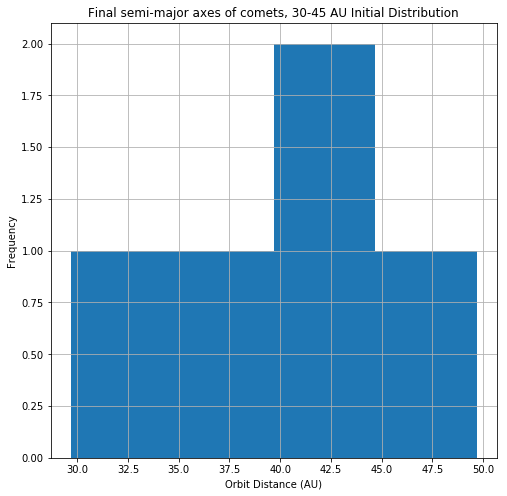

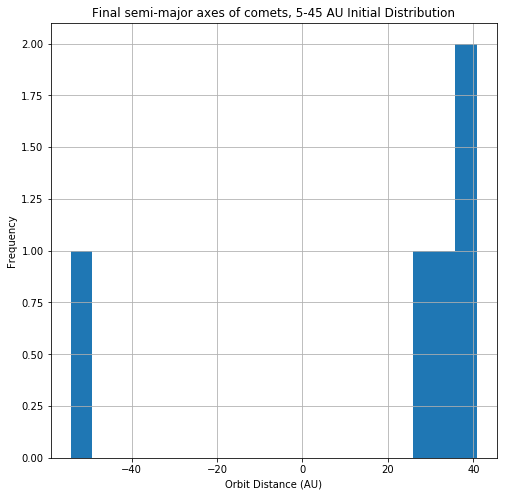

In [555]:
#Plot histogram of comet semi-major axis (final positions)
a_orbits_1 = list(orbits_1)
for i in range(len(a_orbits_1)):
    a_orbits_1[i] = float((str(a_orbits_1[i]).split('=', 1)[-1]).split(' ',1)[0])
print(a_orbits_1[4:])
plothist(a_orbits_1[4:],dist_name_1)

#Plot histogram of comet semi-major axis (final positions)
a_orbits_2 = list(orbits_2)
for i in range(len(a_orbits_2)):
    a_orbits_2[i] = float((str(a_orbits_2[i]).split('=', 1)[-1]).split(' ',1)[0])
print(a_orbits_2[4:])
plothist(a_orbits_2[4:],dist_name_2)

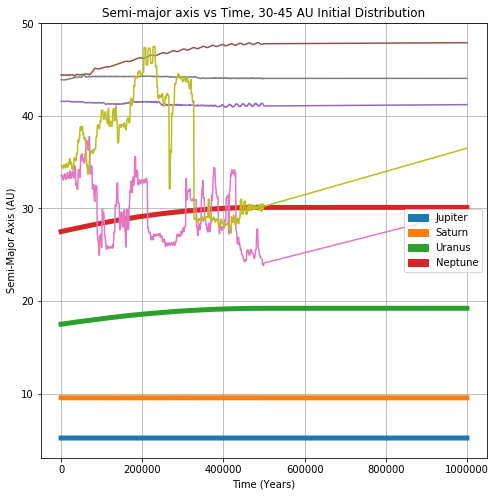

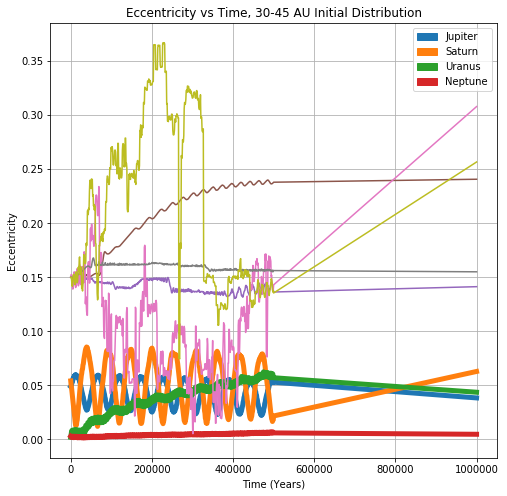

In [556]:
#Plot orbit distances wrt time
plot_a_time(orbits_list_1,t_list_1,dist_name_1)
plot_e_time(orbits_list_1,t_list_1,dist_name_1)

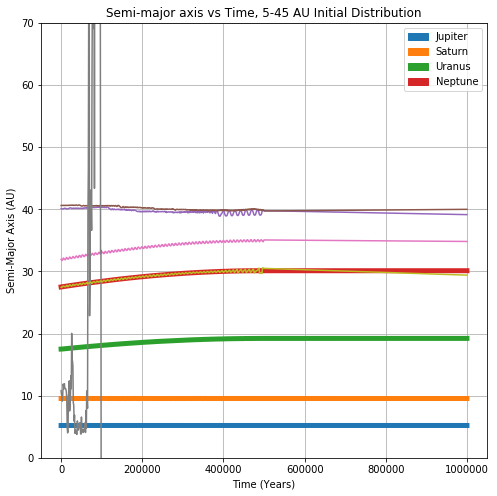

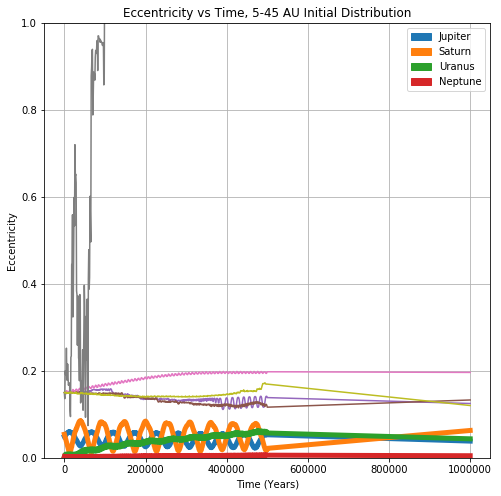

In [557]:
plot_a_time(orbits_list_2,t_list_2,dist_name_2)
plot_e_time(orbits_list_2,t_list_2,dist_name_2)